### Introduction

Currency counterfeiting poses a significant risk to financial systems, requiring reliable and data-driven methods for detection. This project focuses on building a machine learning model capable of __classifying banknotes as genuine or counterfeit__ based on physical measurement features.

This [Kaggle dataset](https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills/data) contains dimensional attributes extracted from both real and fake bills, with the target variable indicating whether a bill is genuine. The objective is to develop a classification model that achieves high predictive performance while __minimizing the risk of falsely classifying counterfeit bills as genuine__, which carries higher real-world cost.

![money](https://i.etsystatic.com/6088981/r/il/a8e672/191673751/il_570xN.191673751.jpg)

___K-Nearest Neighbors (KNN)__ classifier was selected as a baseline model due to its simplicity, interpretability, and ability to capture non-linear relationships in structured data. To ensure reliable evaluation, the project incorporates data preprocessing, feature selection, stratified cross-validation, and systematic hyperparameter tuning within a reproducible machine learning pipeline._

Table of contents:
* Data Preparation
* Data Modeling
    - Baseline Model: Logistic Regression
    - KNN Model: Pipeline & Optimization
* Model Evaluation (KNN
* Model Comparison & Selection
* Limitations & Future Work

### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, confusion_matrix

file = pd.read_csv("fake_bills.csv", sep = ";")
bills_data = pd.DataFrame(file)

In [2]:
bills_data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


The target variable is 'is_genuine' that holds value True for real bills and False for fake ones.

In [3]:
bills_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Bills dataset contains 1500 rows and 7 columns.

In [4]:
bills_data.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [5]:
# Check for duplicates
# bills_data[bills_data.duplicated()]
print("There is {} duplicated entries in the dataset.".format(bills_data.duplicated().sum()))

There is 0 duplicated entries in the dataset.


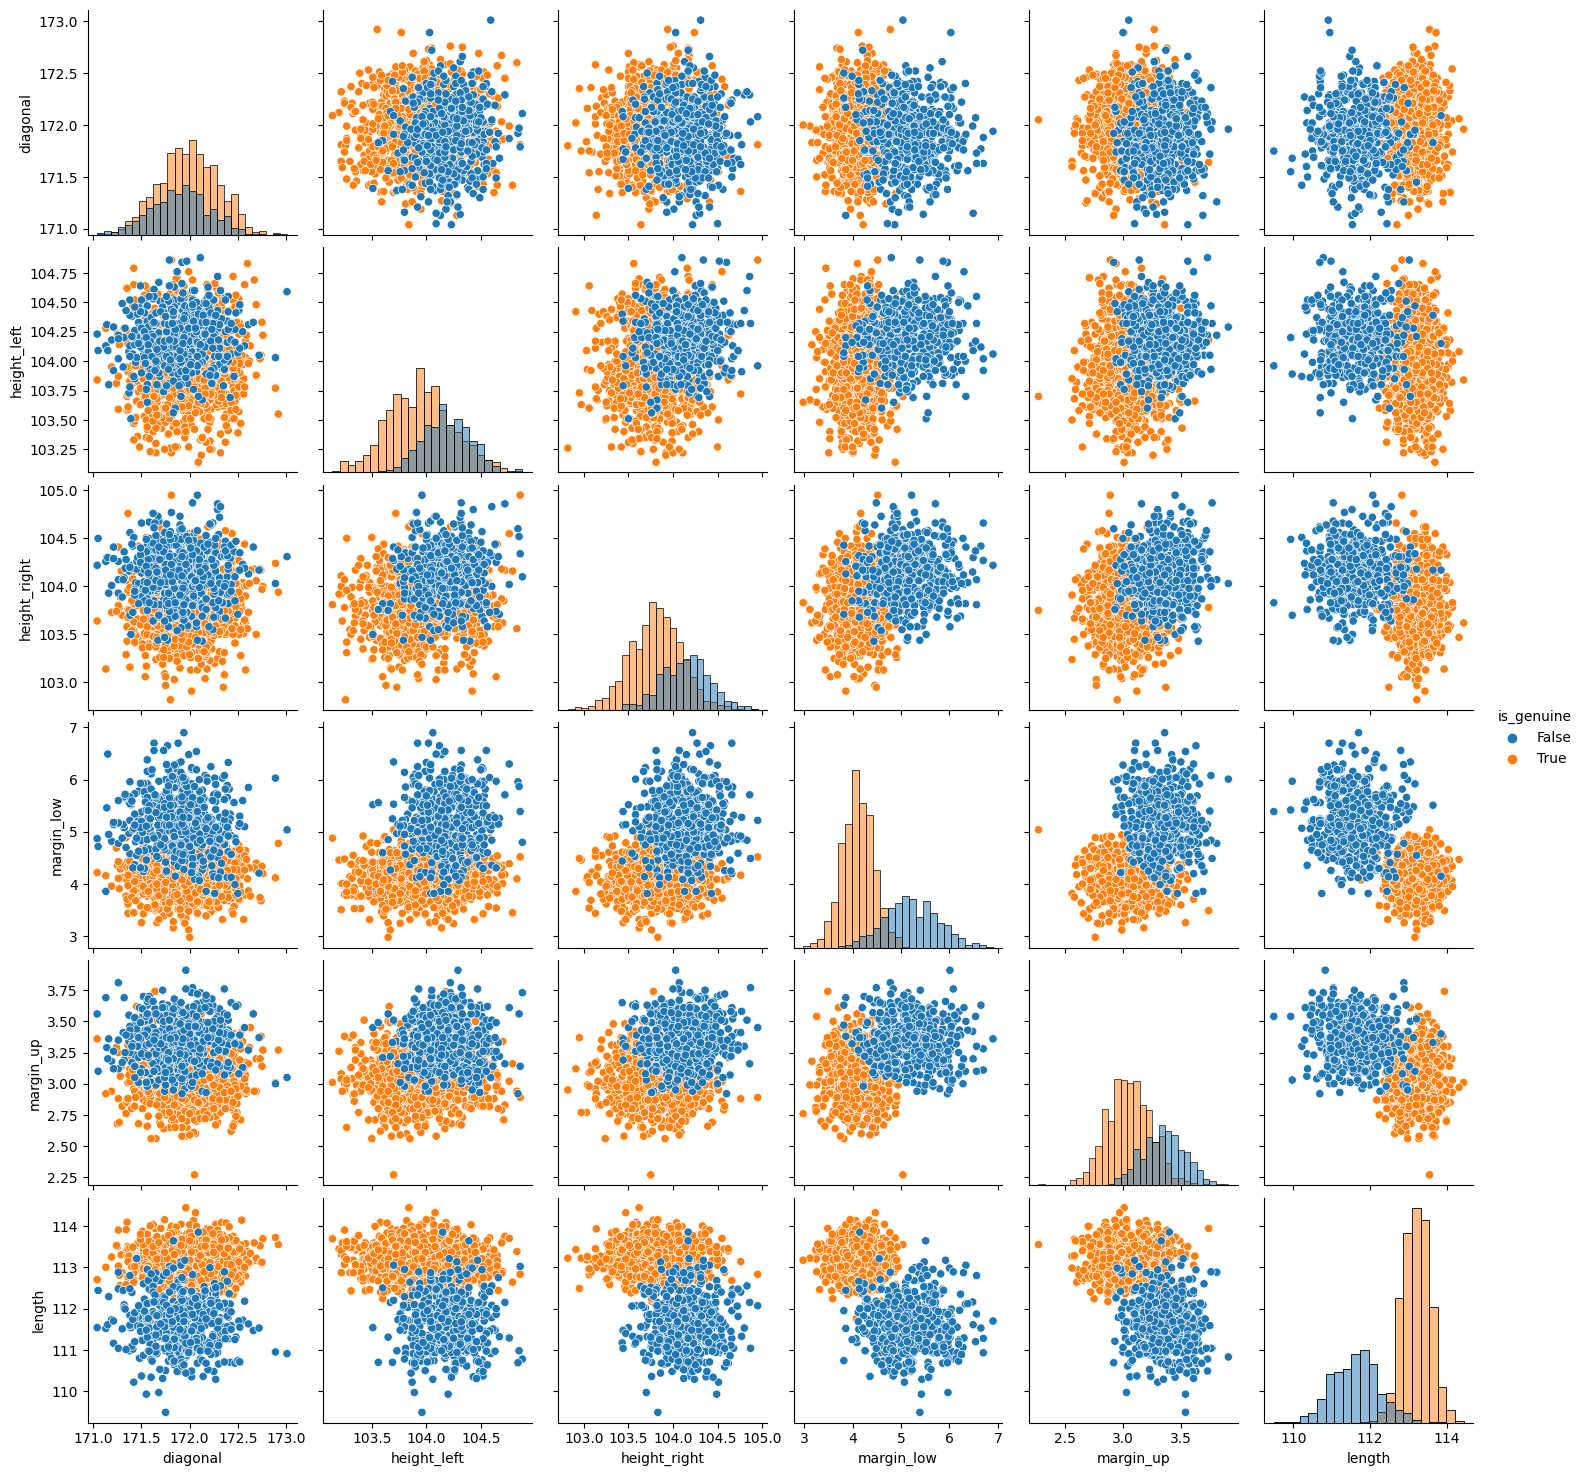

In [6]:
# Let's visual the data to get a sense of distributions and relations between different variables

features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
target = 'is_genuine'

# Concatenating features and target variable into a single dataframe
data_vis = bills_data[features + [target]]


import warnings
warnings.filterwarnings("ignore", message="The figure layout has changed to tight")

# Plotting pairplot
sns.pairplot(data_vis, hue=target, diag_kind='hist')
plt.show()

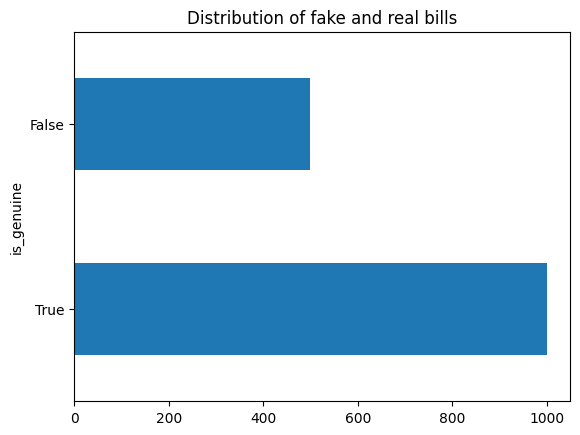

In [7]:
# Let's chek the distribution of taget variable
bills_data.is_genuine.value_counts().plot(kind = 'barh')

plt.title("Distribution of fake and real bills")
plt.show()

### Data Modeling

In this dataset, there's an imbalance where there are twice as many entries labeled as real bills (1000) compared to those marked as fake. Dealing with imbalanced datasets presents a challenge because most machine learning techniques, including KNN, tend to overlook the minority class, leading to biased model performance where the majority class is favored.

To address this, we will use StratifiedKFold as it ensures that each fold in our cross-validation maintains the same class distribution as the entire dataset. This helps to achieve more reliable and consistent evaluation of our model's performance, particularly in handling both the majority and minority classes effectively.
<!-- To address this issue, we'll apply _SMOTE (Synthetic Minority Over-sampling Technique)_ to oversample the fake bills data, ensuring a more balanced representation of both classes.<br>Additionally, to prevent data leakage and ensure accurate model evaluation, we'll first split the data into training and testing sets. This ensures that the model is evaluated on unseen data, providing a more reliable estimate of its performance. -->

In [8]:
# # Sampling data for fake bills to balance available dataset
# from imblearn.over_sampling import SMOTE

# # Instantiate SMOTE with a 1:1 ratio
# smote = SMOTE(sampling_strategy=1, random_state=42)

# # Resample the dataset
# X_train, y_train = smote.fit_resample(X_train, y_train)

# This segment of code is excluded because instead we implemented StratifiedKFold

In [9]:
# Separate features and target variable
y = bills_data.is_genuine
X = bills_data.drop("is_genuine", axis=1)

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

#### Baseline Model: Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score

# Baseline pipeline
baseline_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train baseline model
baseline_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_baseline = baseline_pipeline.predict(X_test)

# Evaluate baseline
print("Baseline Logistic Regression")
print("Test Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_baseline)))
print("Test Precision: {:.2%}".format(precision_score(y_test, y_pred_baseline)))


Baseline Logistic Regression
Test Accuracy: 99.00%
Test Precision: 99.00%


As an initial benchmark, a logistic regression model was trained to establish a baseline level of performance. This provides a reference point for evaluating whether more complex models offer meaningful improvements.

#### KNN Model: Pipeline & Optimization

In [12]:
imputer = KNNImputer()
scaler = StandardScaler()
selector = SelectKBest(score_func=f_classif)
model = KNeighborsClassifier()

pipeline = Pipeline(steps=[
    ('preprocessor', imputer),
    ('scaler', scaler),
    ('feature_selection', selector),
    ('classifier', model)
])

param_grid = {'preprocessor__n_neighbors': range(1,10),
              'feature_selection__k': range(1, X_train.shape[1] + 1),
              'classifier__n_neighbors': range(1, 10)
             }
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring='accuracy')


grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print('Accuracy score on train set: %.2f'% grid_search.score(X_train, y_train))

Accuracy score on train set: 0.99


In [13]:
# Visual representation of our pipeline
from sklearn import set_config

set_config(display='diagram')
display(pipeline)

Pipeline(steps=[('preprocessor', KNNImputer()),
                ('feature_selection', SelectKBest()),
                ('classifier', KNeighborsClassifier())])

In [14]:
# Let's see parametars choosen by the grid search
print('Best parameters:', grid_search.best_params_)
print('Best cross-validation score (accuracy):', grid_search.best_score_)
print('Train set score:', grid_search.score(X_train, y_train))

# Access the best feature selector from the grid search
best_selector = grid_search.best_estimator_.named_steps['feature_selection']

# Get support tells us which features were selected
support = best_selector.get_support()

selected_feature_names = X_train.columns[support]

print('Selected feature names:', selected_feature_names)

Best parameters: {'classifier__n_neighbors': 6, 'feature_selection__k': 3, 'preprocessor__n_neighbors': 1}
Best cross-validation score (accuracy): 0.9908333333333333
Train set score: 0.9916666666666667
Selected feature names: Index(['margin_low', 'margin_up', 'length'], dtype='object')


### Model Evaluation (KNN)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Test Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("Test Precision: {:.2%}".format(precision_score(y_test, y_pred)))
print("Test Recall: {:.2%}".format(recall_score(y_test, y_pred)))
print("Test F1-score: {:.2%}".format(f1_score(y_test, y_pred)))

Test Accuracy: 98.33%
Test Precision: 98.51%
Test Recall: 99.00%
Test F1-score: 98.75%


Precision was prioritized as a key evaluation metric to reduce the risk of falsely classifying counterfeit bills as genuine. Accuracy and recall were also reported to provide a balanced view of overall performance and class-specific behavior.

Consistent performance across training, cross-validation, and test sets suggests that the model generalizes well and does not exhibit significant overfitting.

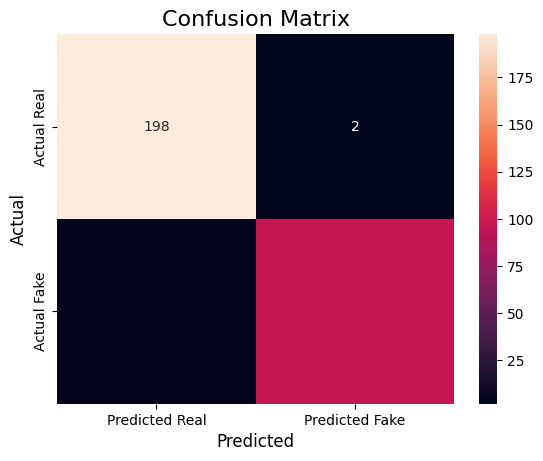

Confusion matrix values:
[[198   2]
 [  3  97]]


In [18]:
cm = confusion_matrix(y_test, y_pred, labels=[True, False])

#Plotting the confusion matrix
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Predicted Real','Predicted Fake'],
            yticklabels=['Actual Real','Actual Fake'])
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()
print("Confusion matrix values:")
print(cm)

Given confusion matrix indicates a model that performs well on the given data, correctly classifying instances from both classes (real and fake bills) with high accuracy and very few errors.

### Model Comparison & Selection

In [17]:
results = pd.DataFrame({
    'Model': ['Logistic Regression (Baseline)', 'KNN (Optimized)'],
    'Test Accuracy': [
        accuracy_score(y_test, y_pred_baseline),
        accuracy_score(y_test, y_pred)
    ],
    'Test Precision': [
        precision_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred)
    ]
})

results


,Model,Test Accuracy,Test Precision
0,Logistic Regression (Baseline),0.990000,0.990050
1,KNN (Optimized),0.983333,0.985075


A logistic regression model was used as a baseline to establish a performance benchmark. It achieved very strong results, with 99.0% accuracy and 99.0% precision, indicating that the dataset is well-structured and the features are highly informative.

The K-Nearest Neighbors (KNN) model was developed and optimized through a pipeline that included imputation, feature selection, and hyperparameter tuning. While the KNN model demonstrated the workflow for building more complex models, it did not outperform the baseline, achieving slightly lower test accuracy (98.3%) and precision (98.5%).

<!-- ## Future Work
Integrating feature selection techniques such as SelectKBest from sklearn could further enhance the model's:
* _Computational Efficiency_: Selecting the most relevant features can lead to faster training and prediction times, crucial for real-time and large-scale applications.

* _Model Interpretability_: Simplifying the model by selecting only the most informative features improves its interpretability, facilitating a deeper understanding of the underlying factors driving predictions.

* _Robustness and Generalizability_: Removing noise or irrelevant features through feature selection enhances the model's robustness, making it more resilient to overfitting and improving its generalizability to unseen data.

By incorporating feature selection, model becomes more efficient, interpretable, and generalizable, making it better suited for real-world deployment and broader applications. -->

### Limitations & Future Work

#### Limitations

* The dataset is relatively small and balanced, limiting the need for more complex models.
* KNN is sensitive to feature scaling and distributions, which affected performance.
* Only basic resampling techniques and cross-validation were explored; other approaches could be evaluated.

#### Future Work

* Compare additional models such as tree-based or ensemble methods.
* Experiment with feature scaling, normalization, and alternative feature selection strategies.
* Explore resampling techniques or synthetic data generation to further evaluate model robustness.